In [ ]:
# How many stacked exposures are required for a detection as a function of distance? 

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


# Imports and setup

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.units as u
import os
from astropy.io import fits
from astropy.table import Table, QTable
from astroduet.background import background_pixel_rate
from astroduet.config import Telescope
from astroduet.utils import duet_abmag_to_fluence
from astroduet.image_utils import construct_image, estimate_background, find, ap_phot
from astroduet.diff_image import py_zogy, calculate_diff_image
from astroduet.lightcurve import get_lightcurve, lightcurve_through_image

# Telescope parameters
duet = Telescope()
[bgd_band1, bgd_band2] = background_pixel_rate(duet, low_zodi = True)
psf_fwhm_pix = duet.psf_fwhm / duet.pixel

# Simulation parameters
start_times = np.array([1800,3000,4200]) * u.s   # 30,50,70 minutes in seconds
distances = np.array([100,150,200,250,300]) * u.Mpc
frame = np.array([30,30])
exposure = 300 * u.s
psf_array = duet.psf_model(x_size=5,y_size=5).array

# 6 is oversampling used in construct_image() 
# - to-do: update sim_galaxy to accept r_eff in arcsec rather than pixels, so we can be agnostic about oversampling
oversample = 6
r_eff_init = 16.5/(duet.pixel.value/oversample) # Average r_eff for spiral galaxy at 100 Mpc, in pixels


# Suppress daophot warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)

In [15]:
# Now that we have the files, loop through them, adding them until we reach a detection threshold of 5 sigma
debugdir = os.path.join(os.getcwd(), 'debug_imgs')

results = Table(names=('distance', 'pos', 'start_time', 'model', 'num_exp'), 
                dtype=('i2', 'i2', 'f2', 'S5', 'i2'))

# Do this all 10 times each for averages 

for i in range(10):

    # Loop through distances
    distances = np.array([100,150,200,250,300]) * u.Mpc
    err = False
    for distance in distances:
        r_eff = r_eff_init * ((100*u.Mpc)**2 / distance**2) # r_eff for spiral galaxy at distance, in pixels
        r_eff = r_eff.value

        # Loop through three different source positions: r_eff*2, r_eff, r_eff/2, called 1, 2, 3
        for x_0, pos in zip([r_eff*2, r_eff, r_eff/2], [1,2,3]):            

            # Galaxy parameters
            gal_params = {'magnitude': 24, 'r_eff': r_eff, 'n': 1, 'theta': 0, 'ellip': 0.5, 'x_0': x_0, 'y_0': 0}

            # Generate combined reference image for this galaxy/source setup
            nexp = 5
            ref_image1 = construct_image(frame, exposure, duet=duet, band=duet.bandpass1,
                                         gal_type='custom', gal_params=gal_params, sky_rate=bgd_band1, n_exp=nexp)
            ref_image2 = construct_image(frame, exposure, duet=duet, band=duet.bandpass2,
                                         gal_type='custom', gal_params=gal_params, sky_rate=bgd_band2, n_exp=nexp)
            total_ref_rate = (ref_image1 + ref_image2) / (exposure * nexp)
            ref_bkg, ref_bkg_rms_median = estimate_background(total_ref_rate, method='1D', sigma=2)
            ref_bkgsub = total_ref_rate - ref_bkg

            # Loop through different start times
            for start_time in start_times:
                # Loop through different models
                for mod in ['shock','blukn']:

                    # Grab the lightcurve files we need 
                    name = '{}_{}Mpc_pos{}_{}s'.format(mod,np.int(distance.value),pos,np.int(start_time.value))
                    table = Table.read(os.path.join(debugdir,name,name+'.hdf5'), path='default')

                    # Loop through images, summing until we get a detection
                    img_sum = np.zeros(frame) * u.ph / u.s
                    for row in table:
                        # Add both bands and add them to total summed image
                        img_sum += (row['imgs_D1'] + row['imgs_D2']) * u.ph / u.s

                        # Convert to average rate
                        num_exp = row.index+1
                        img_rate = img_sum / (num_exp)

                        # Estimate background
                        img_bkg, img_bkg_rms_median = estimate_background(img_rate, method='1D', sigma=2)
                        img_bkgsub = img_rate - img_bkg

                        # Make difference image
                        diff_image = calculate_diff_image(img_rate, img_bkgsub, total_ref_rate, ref_bkgsub)

                        # Run find - do we detect an image to 5 sigma?
                        star_tbl, bkg_image, threshold = find(diff_image,psf_fwhm_pix.value,
                                                              method='peaks', background='1D')

                        # Make check lenient within ~a pixel - position can vary a little due to fluctuations
                        sep = np.sqrt((star_tbl['x'] - (frame[0]//2))**2 + (star_tbl['y'] - (frame[0]//2))**2)
                        if len(sep) > 0:
                            closest = np.argmin(sep)
                            if np.amin(sep) <= 2:
                                result, apertures, annulus_apertures = ap_phot(diff_image,star_tbl[closest],
                                                                               duet.read_noise,exposure)

                                # Sanity check, is this close to the rate that you put in:                        
                                found_rate = result['aperture_sum'].value
                                true_rate = duet.fluence_to_rate(row['fluence_D1']).value + \
                                            duet.fluence_to_rate(row['fluence_D2']).value
                                frac_diff = abs(found_rate - true_rate) / true_rate
                                if frac_diff > 0.8:
         #                           print(found_rate, true_rate, frac_diff)
                                    print(mod, start_time.value, pos,distance,frac_diff, 'False Positive')
                                else:
                                    # Source successfully found! End loop
                                    results.add_row((distance, pos, start_time, mod, num_exp))
                                    break
                        if num_exp > 100:
                            print(mod, start_time.value, pos,distance, 'Too many exposures')
                            results.add_row((distance, pos, start_time, mod, -1))
                            failref, failrefbkgsub = total_ref_rate, ref_bkgsub
                            faildist, failpos, failtime = np.int(distance.value), pos, np.int(start_time.value)
                            break


    #                 # Store the number of exposures that were required to detect the source in this setup


blukn 1800.0 2 100.0 Mpc [2.14913943] False Positive
blukn 3000.0 2 100.0 Mpc [0.92937162] False Positive
blukn 4200.0 2 100.0 Mpc [0.80382087] False Positive
blukn 1800.0 3 100.0 Mpc [1.73647895] False Positive
blukn 4200.0 3 100.0 Mpc [1.11838333] False Positive
blukn 3000.0 1 200.0 Mpc [2.16450267] False Positive
blukn 3000.0 1 200.0 Mpc [1.17834905] False Positive
blukn 1800.0 2 200.0 Mpc [3.65216946] False Positive
blukn 1800.0 2 200.0 Mpc [3.14363626] False Positive
blukn 1800.0 2 200.0 Mpc [1.97318027] False Positive
blukn 1800.0 2 200.0 Mpc [1.46459999] False Positive
blukn 1800.0 2 200.0 Mpc [0.92290253] False Positive
blukn 3000.0 2 200.0 Mpc [1.3065451] False Positive
blukn 1800.0 2 100.0 Mpc [2.15994887] False Positive
blukn 4200.0 2 100.0 Mpc [1.02061073] False Positive
blukn 4200.0 1 150.0 Mpc [1.22608499] False Positive
blukn 4200.0 2 150.0 Mpc [0.83932838] False Positive
blukn 1800.0 3 150.0 Mpc [1.23275918] False Positive
blukn 3000.0 3 150.0 Mpc [0.83864336] False Pos

blukn 1800.0 3 200.0 Mpc [1.23791584] False Positive
blukn 1800.0 3 200.0 Mpc [0.83744257] False Positive
blukn 1800.0 2 300.0 Mpc Too many exposures
blukn 3000.0 2 300.0 Mpc Too many exposures


blukn 1 - 300.0 Mpc 24.88888888888889 8.359219055024013 9
blukn 1 -- 300.0 Mpc 24.428571428571427 18.60765697123589 7
blukn 1 : 300.0 Mpc 24.666666666666668 7.803133273813083 6
blukn 2 - 300.0 Mpc 22.142857142857142 3.313546715640915 7
blukn 2 -- 300.0 Mpc 20.857142857142858 4.290473547908916 7
blukn 2 : 300.0 Mpc 9.777777777777779 7.465145347662589 9
blukn 3 - 300.0 Mpc 34.125 13.41116605668575 8
blukn 3 -- 300.0 Mpc 24.2 6.337191807101945 5
blukn 3 : 300.0 Mpc 23.666666666666668 9.309493362512628 9


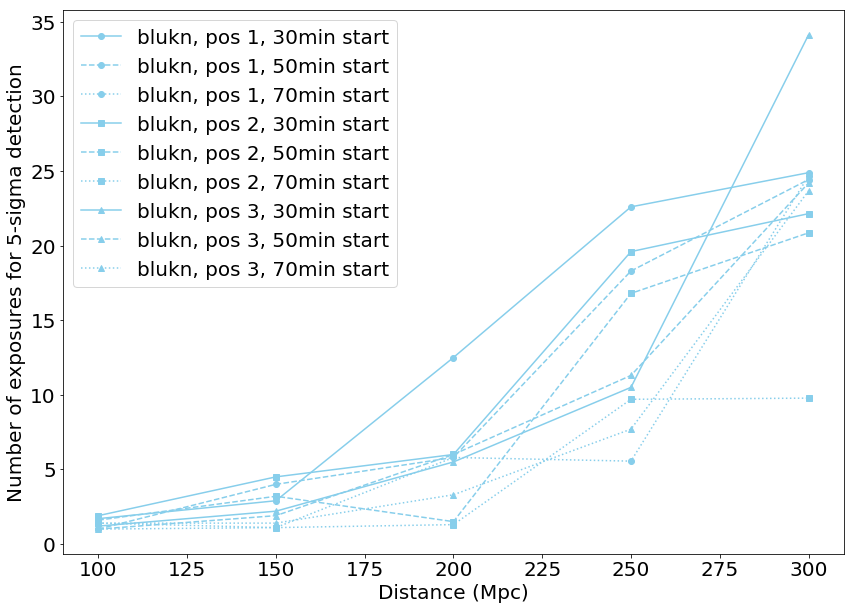

In [16]:
# Results plots - number of exposures vs distance for different models, start times, source positions
font = {'size': 20}
matplotlib.rc('font', **font)

plt.figure(figsize=(14, 10))

# Loop through three different source positions
for mod, col in zip(['shock','blukn'],['coral','skyblue']):
    if mod is 'shock':
        continue
    # Loop through different models
    for pos,m in zip([1,2,3],['o','s','^']):

        # Loop through different start times
        for start_time, ls in zip(start_times,['-','--',':']):

            # Loop through distances
            av_num = []
            std_num = []
            for dist in distances:

                mask = (results['pos'] == pos) & \
                    (results['start_time'] == np.int(start_time.value)) & \
                    (results['model'] == mod) & (results['distance'] == dist.value) & \
                    (results['num_exp'] > 0)

                num = results[mask]['num_exp']
                av_num.append(np.mean(num))
                std_num.append(np.std(num))
                
                if dist.value == 300:
                    print(mod, pos,ls, dist, np.mean(num), np.std(num), len(num))

            plt.plot(distances.value,av_num,marker=m,color=col,linestyle=ls,
                         label='{}, pos {}, {}min start'.format(mod,pos,np.int(start_time.to(u.min).value)))
plt.xlabel('Distance (Mpc)')
plt.ylabel('Number of exposures for 5-sigma detection')
#plt.ylim(0,22)
plt.legend(loc=2)


# blukn detected out to 300 Mpc 60-70% of the time.
# The rest of the time, the rms noise in the reference image dominates at high numbers of exposures

blukn_300Mpc_pos2_3000s failed - checking why
0.10958227185670451 ph / s
 x   y 
--- ---
0.10932050303675214 ph / s
 x   y 
--- ---
0.10919082575925798 ph / s
 x   y 
--- ---
0.10905486416004984 ph / s
 x   y 
--- ---
0.10890785101704367 ph / s
 x   y 
--- ---
0.10878213365313395 ph / s
 x   y 
--- ---
0.10869296389321119 ph / s
 x   y 
--- ---
0.10860124715073036 ph / s
 x   y 
--- ---
0.1087147428271621 ph / s
 x   y 
--- ---
0.10854786584861455 ph / s
 x   y 
--- ---
0.1083067644934914 ph / s
 x   y 
--- ---
0.10846275142642721 ph / s
 x   y 
--- ---
0.10858681814066586 ph / s
 x   y 
--- ---
0.10854182114280324 ph / s
 x   y 
--- ---
0.10849954419524328 ph / s
 x   y 
--- ---
0.1082738987188876 ph / s
 x   y 
--- ---
0.10815431320211498 ph / s
 x   y 
--- ---
0.10798639124032938 ph / s
 x   y 
--- ---
0.10779942411607639 ph / s
 x   y 
--- ---


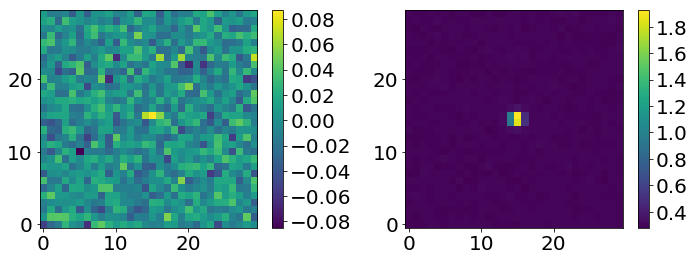

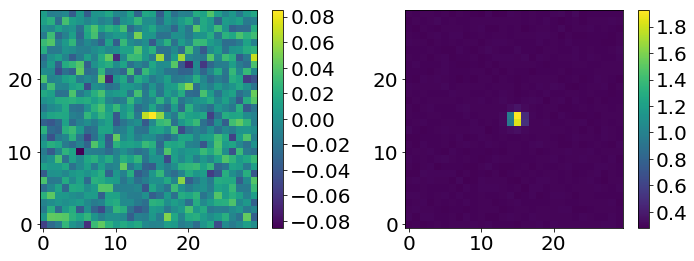

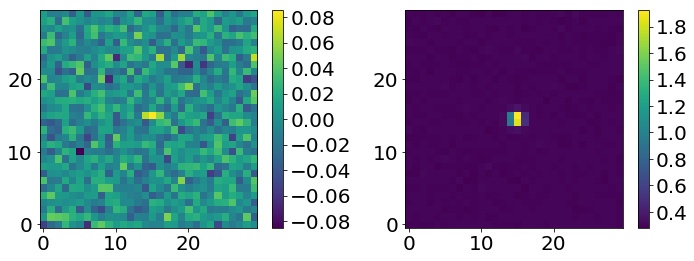

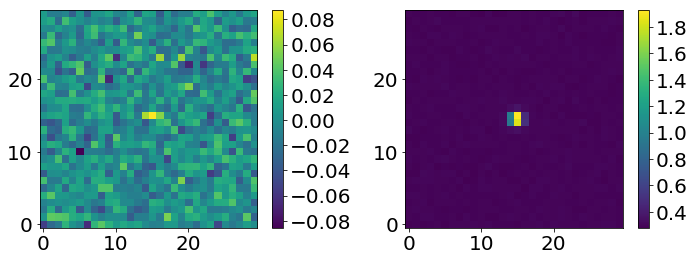

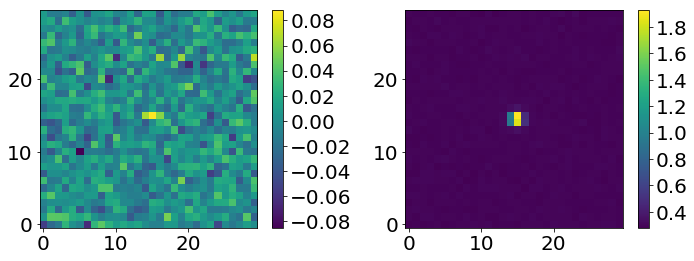

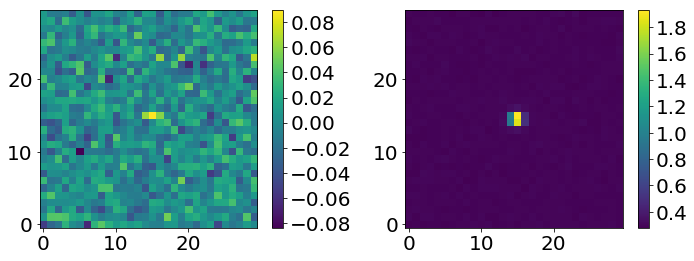

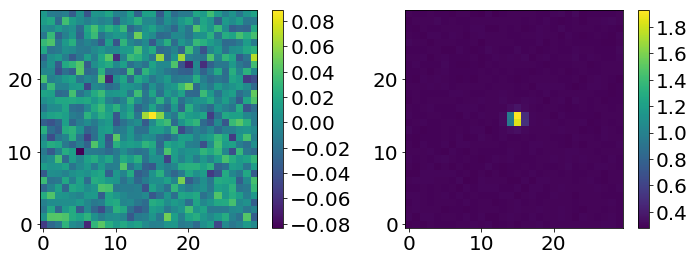

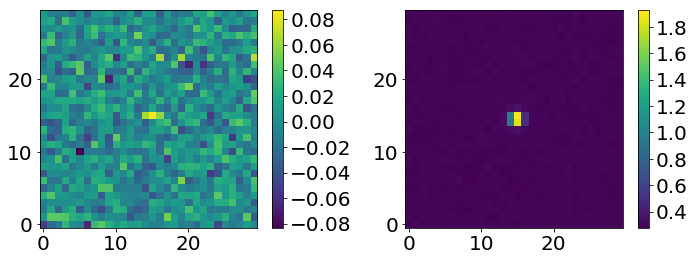

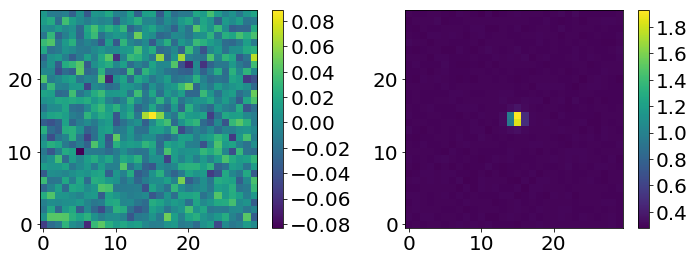

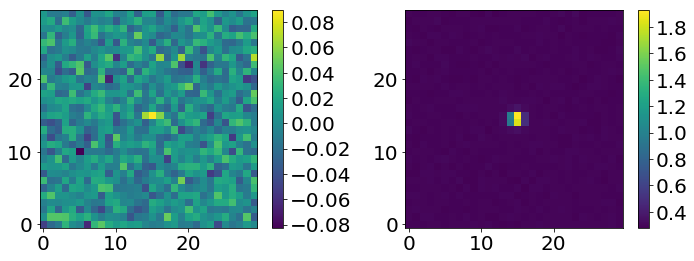

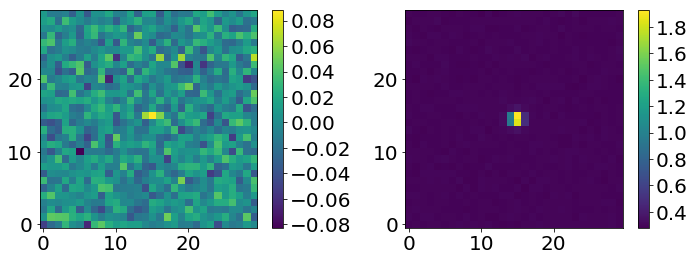

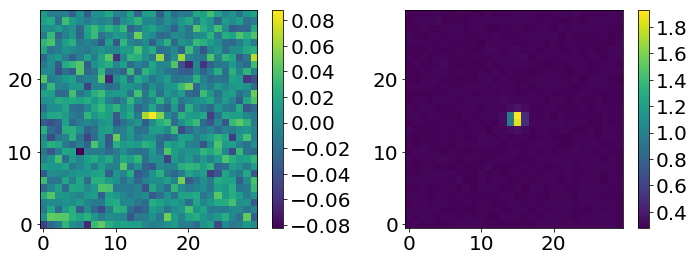

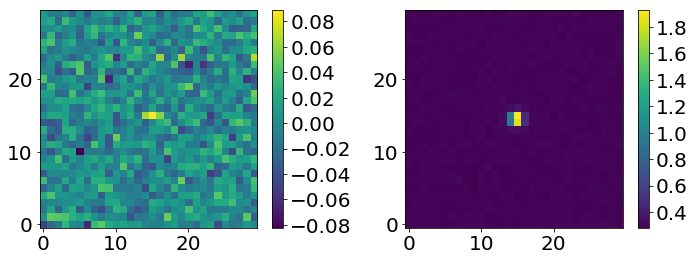

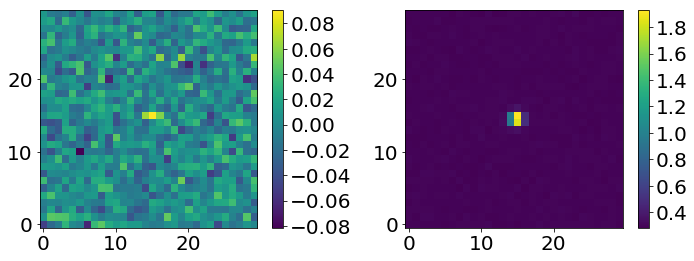

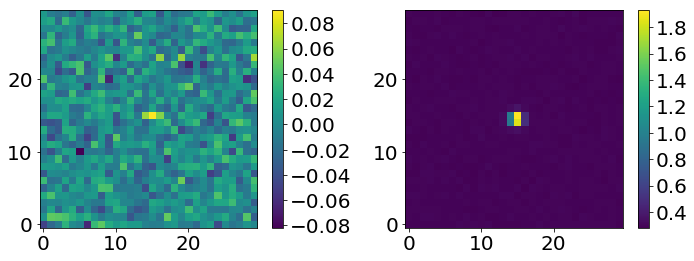

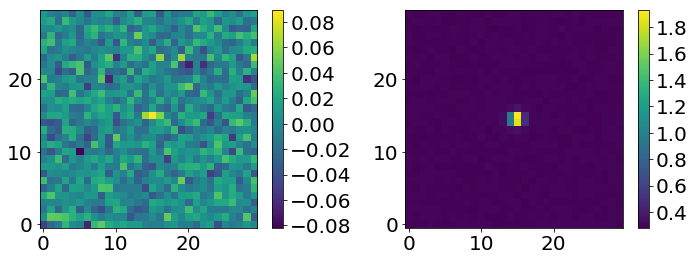

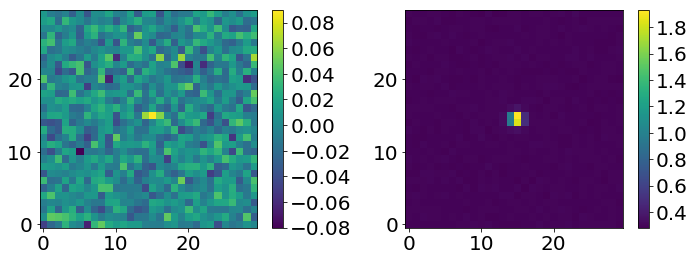

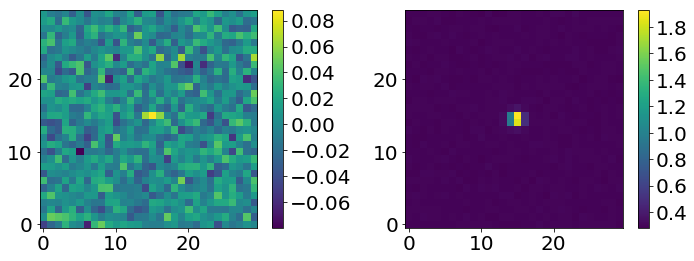

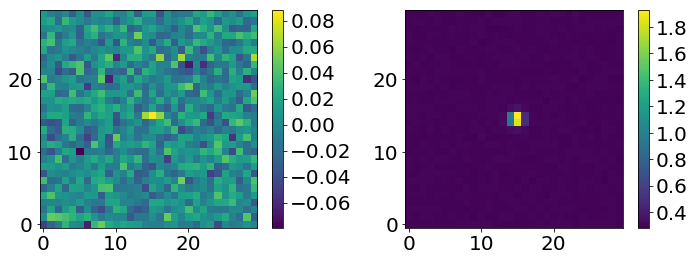

In [17]:
# Sanity checking

r_eff = r_eff_init * ((100*u.Mpc)**2 / (faildist*u.Mpc)**2) # r_eff for spiral galaxy at distance, in pixels
r_eff = r_eff.value

# Galaxy parameters
gal_params = {'magnitude': 24, 'r_eff': r_eff, 'n': 1, 'theta': 0, 'ellip': 0.5, 'x_0': r_eff, 'y_0': 0}

# Grab the lightcurve files we need from the last failed run
name = 'blukn_{}Mpc_pos{}_{}s'.format(faildist,failpos,failtime)
print('{} failed - checking why'.format(name))
table = Table.read(os.path.join(debugdir,name,name+'.hdf5'), path='default')

img_sum = np.zeros(frame) * u.ph / u.s
for row in table:
    # Add both bands and add them to total summed image
    img_sum += (row['imgs_D1'] + row['imgs_D2']) * u.ph / u.s

    # Convert to average rate
    num_exp = row.index+1
    img_rate = img_sum / (num_exp)

    # Estimate background
    img_bkg, img_bkg_rms_median = estimate_background(img_rate, method='1D', sigma=2)
    img_bkgsub = img_rate - img_bkg
    
    if (num_exp > 50) & (num_exp < 70):

        # Make difference image
        diff_image = calculate_diff_image(img_rate, img_bkgsub, failref, failrefbkgsub)

        star_tbl1, _, threshold = find(diff_image,psf_fwhm_pix.value,method='peaks', background='1D')
        print(threshold)
        print(star_tbl1['x','y'])

        plt.figure(figsize=[12,4])
        plt.subplot(121)
        plt.imshow(diff_image.value, cmap='viridis', aspect=1, origin='lower')
        plt.colorbar()
        plt.subplot(122)
        plt.imshow(img_rate.value, cmap='viridis', aspect=1, origin='lower')
        plt.colorbar()

In [13]:
# just a note - I was sanity checking some of the detection results 
# because something didn't seem right with respect to how many observations it was taking 
# to detect the blue kilonova in some cases.
# As it turns out, there can be some cases in which, 
# while we position the source at the centre of the image, 
# the peak ends up being shifted over by a pixel due to fluctuations in the difference image. 
# So when we do our crude check for a peak at the expected pixel, 
# we don't register a detection even when it finds the peak. 
# I introduced that initially way back to ensure it's actually the source we're detecting 
# and not a false alarm elsewhere in the image, 
# but the exact pixel requirement is possibly a little strict 
# (after stacking enough images or with a high enough count rate 
# the peak ends up on the right pixel and it's fine, so it's not the end of the world, 
# just something worth bearing in mind). 